In [16]:
import nltk
from nltk.corpus import brown
import sklearn_crfsuite
from sklearn_crfsuite import CRF, metrics
import string
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
nltk.download('brown')
nltk.download('universal_tagset')
corpus = brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to
[nltk_data]     /Users/parthbatwara/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/parthbatwara/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [5]:
def word2features(sent, i):
    word = sent[i][0]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features

In [6]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for (word, label) in sent]

def sent2tokens(sent):
    return [word for (word, label) in sent]

In [7]:
# Prepare data (use all sentences for cross-validation)
X = [sent2features(s) for s in corpus]
y = [sent2labels(s) for s in corpus]

In [8]:

# Initialize CRF model
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=False
)

In [9]:
# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics for each fold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

In [15]:
# Iterate through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

    # Train CRF
    crf.fit(X_train, y_train)

    # Predict on test set
    y_pred = crf.predict(X_test)

    # Calculate metrics
    labels = list(crf.classes_)
    # Remove 'PUNCT' only if it exists in the labels
    if 'PUNCT' in labels:
        labels.remove('PUNCT')  # Remove punctuation for evaluation

    # Overall metrics
    accuracy = metrics.flat_accuracy_score(y_test, y_pred)
    report = metrics.flat_classification_report(y_test, y_pred, labels=labels, digits=3, output_dict=True)
    
    accuracy_list.append(accuracy)
    precision_list.append(report['weighted avg']['precision'])
    recall_list.append(report['weighted avg']['recall'])
    f1_list.append(report['weighted avg']['f1-score'])

    # Flatten y_test and y_pred for confusion matrix computation
    y_test_flat = [label for sublist in y_test for label in sublist]
    y_pred_flat = [label for sublist in y_pred for label in sublist]
    # Confusion matrix (optional, can store each fold's matrix)
    cm = confusion_matrix(y_test_flat, y_pred_flat, labels=labels)

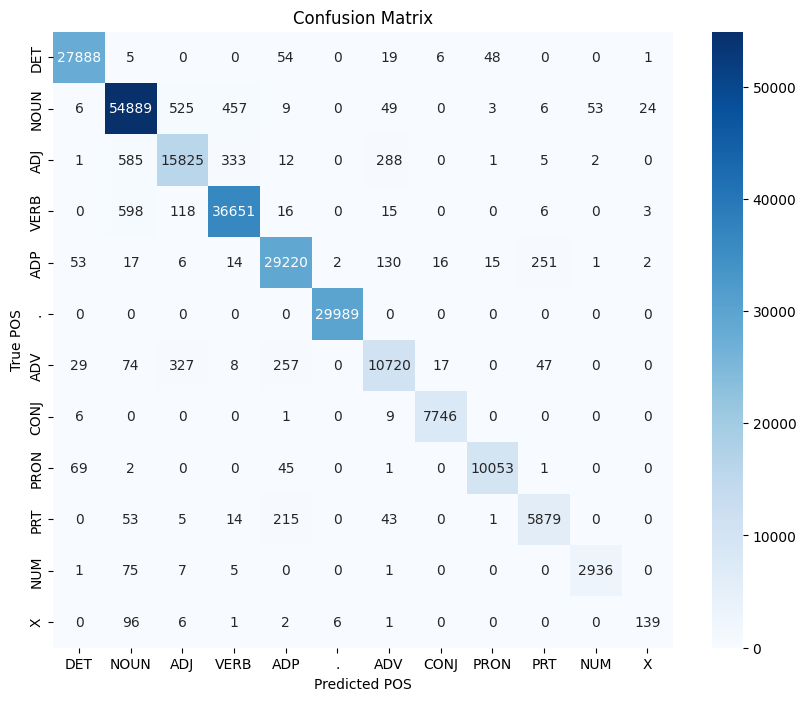

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True POS')
plt.xlabel('Predicted POS')
plt.show()

In [18]:
# Calculate average metrics across all folds
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)

# Print average cross-validation results
print("5-Fold Cross-Validation Results (CRF POS Tagger):")
print(f"Average Accuracy: {avg_accuracy:.3f}")
print(f"Average Precision: {avg_precision:.3f}")
print(f"Average Recall: {avg_recall:.3f}")
print(f"Average F1-score: {avg_f1:.3f}")

5-Fold Cross-Validation Results (CRF POS Tagger):
Average Accuracy: 0.978
Average Precision: 0.978
Average Recall: 0.978
Average F1-score: 0.978
